In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from load_cifar import load_data
import new_model as model


### Load dataset (cifar-10)

In [2]:
data = load_data('C:/Users/k_tej/Documents/TEJA/ML_resources/DL_projects/data_sets/cifar-10-batches-py')
#data = load_data('/floyd/input/cifar_10_batches_py/cifar-10-batches-py')

In [3]:
data.keys()

dict_keys(['train_x', 'train_y', 'test_x', 'test_y'])

In [4]:
(data['train_x'].shape,data['train_y'].shape),(data['test_x'].shape,data['test_y'].shape)

(((50000, 32, 32, 3), (50000,)), ((10000, 32, 32, 3), (10000,)))

### dataset labels

In [5]:
labels=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [6]:
DIM = 32
CH = 3

Label: horse


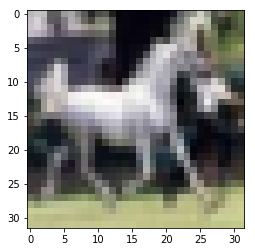

In [7]:
x = np.random.randint(50000)
print('Label: {}'.format(labels[data['train_y'][x]]))
plt.imshow(data['train_x'][x].reshape(DIM,DIM,CH))

### Data preprocessing

#### 1.  One hot encoding 

In [8]:
n_classes = 10
id_mtx = np.identity(n_classes,dtype=np.float32)
data['train_y'] = id_mtx[data['train_y']]
data['test_y'] = id_mtx[data['test_y']]
data['train_y'].shape, data['test_y'].shape

((50000, 10), (10000, 10))

#### 2. Normalize 

In [9]:
data['train_x'] = data['train_x'].astype(np.float32)/255
data['test_x'] = data['test_x'].astype(np.float32)/255

### generate datasets 

In [10]:
batch_size = 100

In [11]:
dtrain_x = tf.data.Dataset.from_tensor_slices(data['train_x'])
dtrain_y = tf.data.Dataset.from_tensor_slices(data['train_y'])
dtrain = tf.data.Dataset.zip(( dtrain_x, dtrain_y )).repeat().batch(batch_size)
dtrain_one_shot = tf.data.Dataset.zip(( dtrain_x, dtrain_y )).batch(batch_size)

dtest_x = tf.data.Dataset.from_tensor_slices(data['test_x'])
dtest_y = tf.data.Dataset.from_tensor_slices(data['test_y'])
dtest = tf.data.Dataset.zip(( dtest_x,dtest_y )).batch(batch_size)


In [12]:
dvalid_x = tf.data.Dataset.from_tensor_slices(data['test_x'][:1000,:,:,:])
dvalid_y = tf.data.Dataset.from_tensor_slices(data['test_y'][:1000])
dvalid = tf.data.Dataset.zip(( dtest_x,dtest_y )).repeat().batch(batch_size)
(dtrain,dtest,dvalid)

(<BatchDataset shapes: ((?, 32, 32, 3), (?, 10)), types: (tf.float32, tf.float32)>,
 <BatchDataset shapes: ((?, 32, 32, 3), (?, 10)), types: (tf.float32, tf.float32)>,
 <BatchDataset shapes: ((?, 32, 32, 3), (?, 10)), types: (tf.float32, tf.float32)>)

### Iterators 

In [13]:
iterator = tf.data.Iterator.from_structure(dtrain.output_types,dtrain.output_shapes)
get_batch = iterator.get_next()

#for train
dtrain_init = iterator.make_initializer(dtrain)
#for test
dtest_init = iterator.make_initializer(dtest)
#for validation
dvalid_init = iterator.make_initializer(dvalid)
#for one shot
one_shot_init = iterator.make_initializer(dtrain_one_shot)

### setting hyperparameters

In [14]:
epochs = 1
epochs = int(epochs*50000/(batch_size))
probability_keep = 0.5

In [15]:
is_train = tf.placeholder(shape=(),dtype=tf.bool)
prob_keep = tf.placeholder(shape=(),dtype=tf.float32)
current_model = model.CNN(get_batch[0], is_train, prob_keep)
param_info = current_model.total_params()

varname : conv_1/weight:0 [Dimension(3), Dimension(3), Dimension(3), Dimension(64)]
varname : conv_1/bias:0 [Dimension(64)]
varname : conv_1/batch_normalization/gamma:0 [Dimension(64)]
varname : conv_1/batch_normalization/beta:0 [Dimension(64)]
varname : conv_2/weight:0 [Dimension(5), Dimension(5), Dimension(64), Dimension(128)]
varname : conv_2/bias:0 [Dimension(128)]
varname : conv_2/batch_normalization/gamma:0 [Dimension(128)]
varname : conv_2/batch_normalization/beta:0 [Dimension(128)]
varname : conv_3/weight:0 [Dimension(5), Dimension(5), Dimension(128), Dimension(256)]
varname : conv_3/bias:0 [Dimension(256)]
varname : conv_3/batch_normalization/gamma:0 [Dimension(256)]
varname : conv_3/batch_normalization/beta:0 [Dimension(256)]
varname : dense/kernel:0 [Dimension(4096), Dimension(1000)]
varname : dense/bias:0 [Dimension(1000)]
varname : batch_normalization/gamma:0 [Dimension(1000)]
varname : batch_normalization/beta:0 [Dimension(1000)]
varname : dense_1/kernel:0 [Dimension(1000

In [16]:
logits=current_model.logits
logits

<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 10) dtype=float32>

### Optimization 

In [17]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=get_batch[1],logits=logits))
tf.summary.scalar("losses",loss)
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)
predictions = tf.argmax(logits,axis=1)
equality = tf.equal(predictions,tf.argmax(get_batch[1],axis=1))
accuracy = tf.reduce_mean(tf.cast(equality,tf.float32))
tf.summary.scalar("accuracy",accuracy)
init_op = tf.global_variables_initializer()

In [18]:
log_dir = 'floyd/home/logs'
print(log_dir)
t_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter(log_dir)

floyd/home/logs


In [19]:
train_stack = np.random.rand(1,n_classes)
test_stack = np.random.rand(1,n_classes)
valid_log_acc = []
train_log_acc=[]
test_acc=[]
train_acc=[]
with tf.Session() as sess:
    writer.add_graph(sess.graph)
    sess.run(init_op)
    train_log_loss = []
    valid_log_loss = []
    for i in range(1,epochs+1):
        sess.run(dtrain_init)
        l,_,acc,s = sess.run([loss,optimizer,accuracy,t_summary],feed_dict={is_train:True,prob_keep:probability_keep})
        writer.add_summary(s,i)
        train_log_loss.append(l)
        
        if i%100 == 0:
            print("epoch :{}, loss :{:.3f}, accuracy :{:.3f}".format(i,l,acc))
            #save_path = saver.save(sess,log_dir+'/curr_model.ckpt')
            valid_iter = 10
            avg_acc = 0
            sess.run(dvalid_init)
            for _ in range(valid_iter):
                acc = sess.run([accuracy],feed_dict = {is_train:False,prob_keep:1.0})
                avg_acc+=acc[0]
            avg_acc = avg_acc*100.0/10
            valid_log_acc.append(avg_acc)
            print("average accuracy :{:.2f}".format(avg_acc))
    
    i = 0
    test_acc = 0
    sess.run(dtest_init)
    while True:
        try:
            acc,test_out = sess.run([accuracy,logits],feed_dict={is_train:False,prob_keep:1.0})
            test_stack = np.vstack((test_stack,test_out))
            i+=1
            test_acc+=acc
        except tf.errors.OutOfRangeError:
            print("number of iter : {}".format(i))
            test_acc = test_acc*100/i
            print("Test accuracy: {}".format(test_acc))
            plt.plot(train_log_loss,label='loss_train',color='r')
            plt.plot(np.array(list(range(1,int(epochs/100)+1)))*100,valid_log_acc,label='acc_train',color='b')
            plt.xlabel('epochs')
            plt.legend()
            plt.show()
            break
    train_acc = 0
    i=0
    sess.run(one_shot_init)
    while True:
        try:
            acc,train_out =sess.run([accuracy,logits],feed_dict={is_train:False,prob_keep:1.0})
            i+=1
            train_stack = np.vstack((train_stack,train_out))
            train_acc+=acc
        except:
            train_acc = train_acc*100/i
            print("train accuracy: {:.3f}".format(train_acc))
            break
    
            

KeyboardInterrupt: 

In [ ]:
output_dict = dict()
output_dict['batch_size'] = batch_size
output_dict['epochs'] = epochs
output_dict['loss'] = np.array(train_log_loss)
output_dict['accuracy'] = np.array(valid_log_acc)
output_dict['test_accuracy'] = np.array(test_acc)
output_dict['train_accuracy'] = np.array(train_acc)


np.save('data_info_epochs_1.npy',output_dict)
np.savetxt('train_stack.csv',train_stack[1:],delimiter=',')
np.savetxt('test_stack.csv',test_stack[1:],delimiter=',')

In [ ]:

np.save('/floyd/home/data_info_epoch_1.npy',output_dict)
np.savetxt('/floyd/home/train_stack.csv',train_stack[1:],delimiter=',')
np.savetxt('/floyd/home/test_stack.csv',test_stack[1:],delimiter=',')



In [ ]:
train_stack.shape